In [2]:
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import math
import numpy as np
component_size = 30
component_thresh = 5
field_range = 3

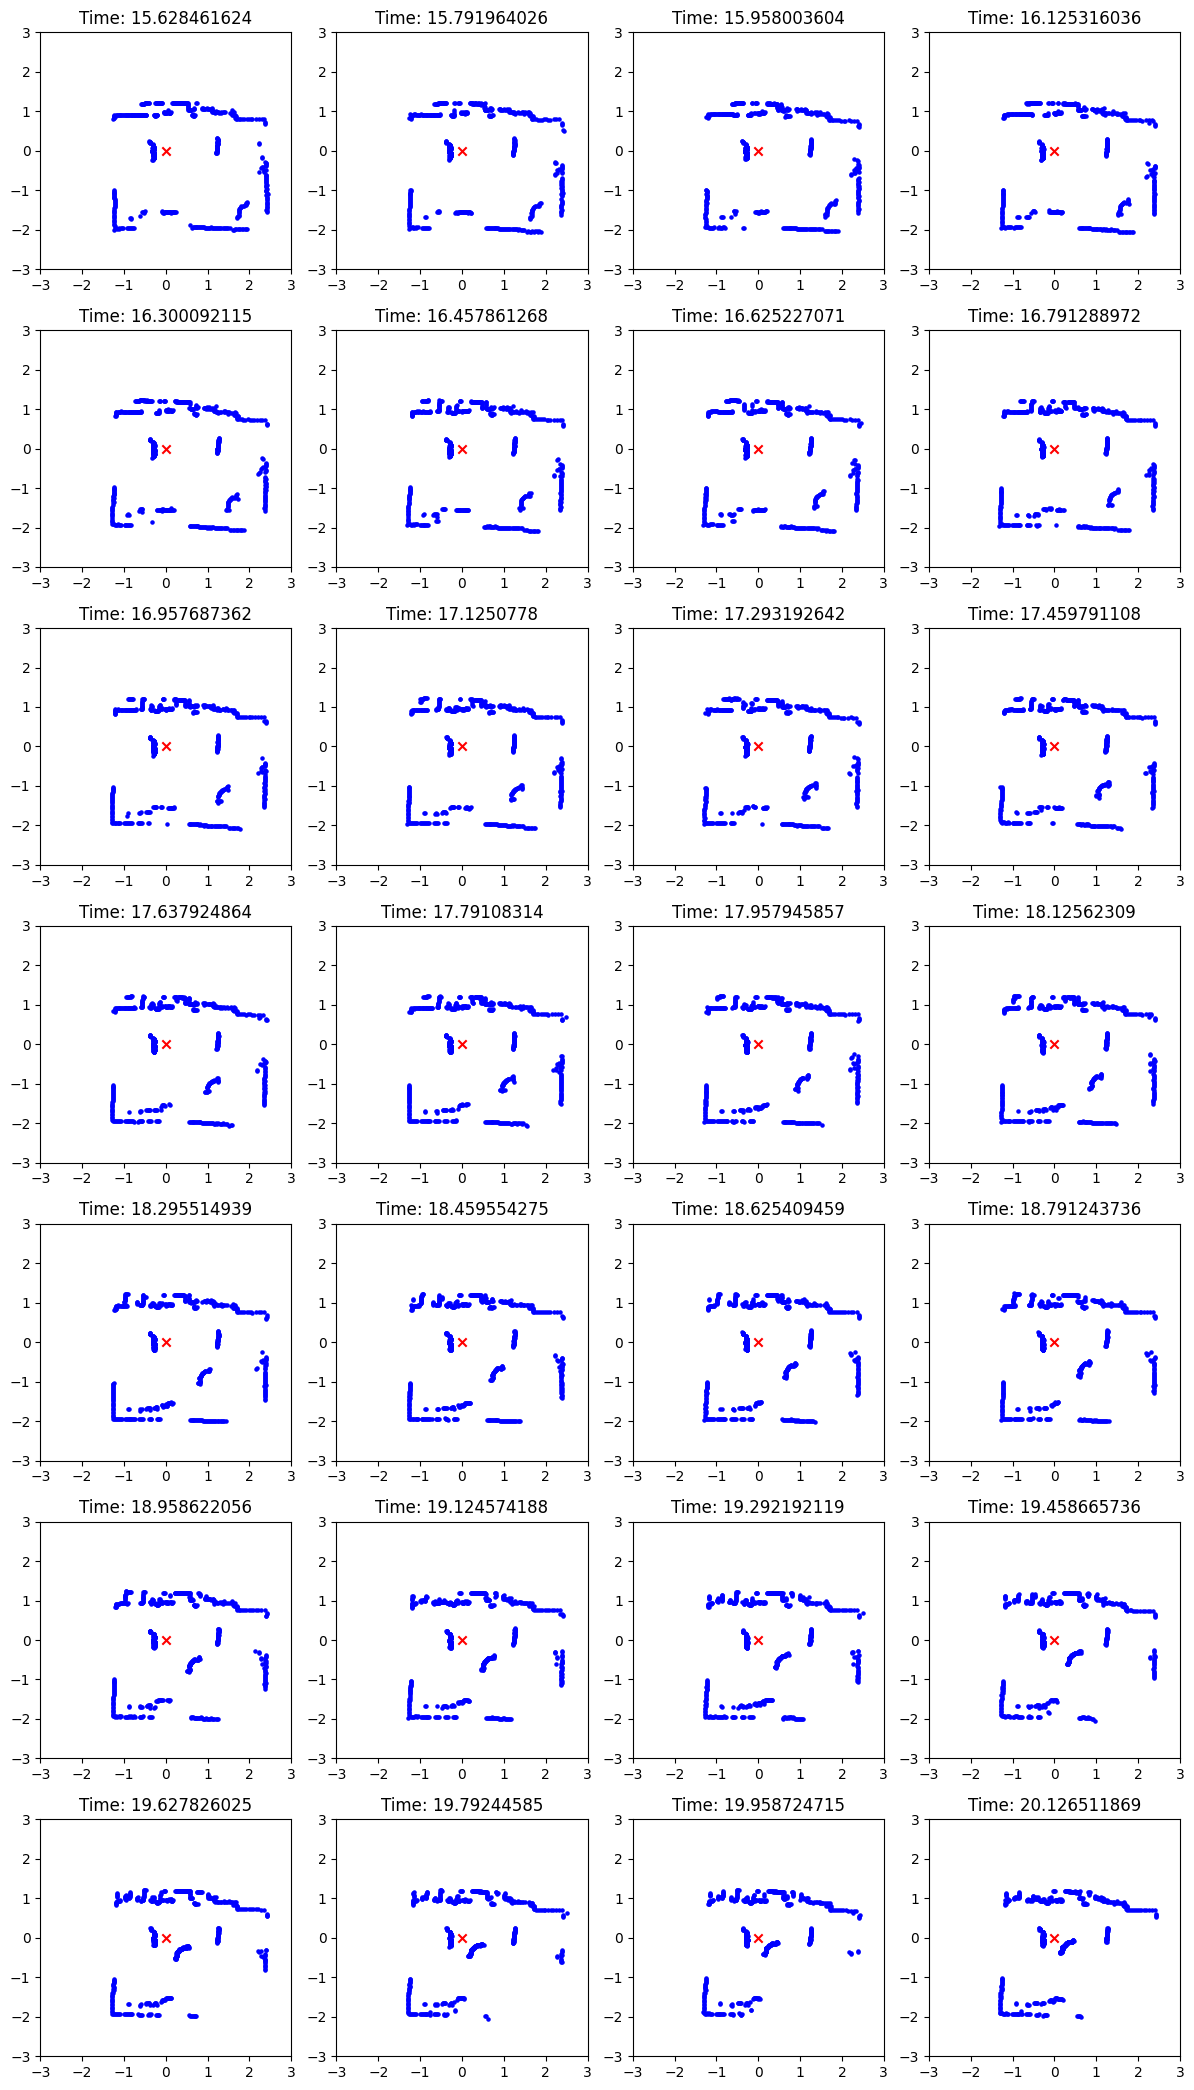

In [3]:
j = 0
file = open('cleaned.txt', 'r')
raw_data = file.readlines()[84:112]
points = []
segments = []
figure, axis = plt.subplots(len(raw_data)//4, 4, figsize=(12, 21))
for line in raw_data:
    
    # Cleaning
    
    stripped = line.replace('\n', ' ').replace('(', ' ').        \
        replace(')', ' ').replace('[', ' ').replace(']', ' ').   \
        replace(':', ',').replace(' ', '').split(',')[2:]
    x = []
    y = []
    for i in range(int(len(stripped)/2)):
        a = float(stripped[2 * i])
        b = float(stripped[2 * i + 1])
        if (abs(a) < field_range and abs(b) < field_range):
            x.append(a)
            y.append(b)
    time = float(line.replace(' ', ',').split(',')[1])
    points.append([x, y])
    segments.append([time])
    
    # Raw visualization

    axis[j//4, j % 4].scatter(x, y, c="blue", s=5)
    axis[j//4, j % 4].scatter(0, 0, c="red", marker='x')
    axis[j//4, j % 4].set_xlim(-field_range, field_range)
    axis[j//4, j % 4].set_ylim(-field_range, field_range)
    axis[j//4, j % 4].set_title("Time: " + str(time))
    j += 1

plt.tight_layout()
plt.show()

In [4]:
for k in range(len(points)):
    x = points[k][0]
    y = points[k][1]
    segments[k].append([0, 0, 0, [], []])
    components = []
    count = 1

    # Slicing/thresholding
    
    grid = [[0 for i in range(component_size)] for j in range(component_size)]
    for i in range(len(x)):
        a = int(math.floor(x[i] / ((2 * field_range)/component_size)) + component_size/2)
        b = int(math.floor(y[i] / ((2 * field_range)/component_size)) + component_size/2)
        grid[a][b] -= 1
        if grid[a][b] == -component_thresh:
            components.append((a, b))
    components.sort()
    
    # Segmentation
    
    for (a, b) in components:
        if grid[a][b] >= 0:
            continue
        label = [(a, b)]
        length = 0
        while length < len(label):
            (i, j) = label[length]
            length += 1
            if grid[i][j] >= 0:
                continue
            label.extend([(i - 1, j)] if i > 0 and grid[i - 1][j] <= 0 else [])
            label.extend([(i - 1, j - 1)] if i > 0 and j > 0                            \
                         and grid[i - 1][j - 1] <= 0 else [])
            label.extend([(i - 1, j + 1)] if i > 0 and j < component_size - 1           \
                         and grid[i - 1][j + 1] <= 0 else [])
            label.extend([(i, j + 1)] if j < component_size - 1                         \
                         and grid[i][j + 1] <= 0 else [])
            label.extend([(i, j - 1)] if j > 0 and grid[i][j - 1] <= 0 else [])
            label.extend([(i + 1, j)] if i < component_size - 1                         \
                         and grid[i + 1][j] <= 0 else [])
            label.extend([(i + 1, j - 1)] if i < component_size - 1 and j > 0           \
                         and grid[i + 1][j-1] <= 0 else [])
            label.extend([(i + 1, j + 1)] if i < component_size - 1 and                 \
                         j < component_size - 1 and grid[i + 1][j + 1] <= 0 else [])
            grid[i][j] = count
        segments[k].append([count, 0, 0, [], []])
        count += 1
    
    # Initial labeling
    
    for i in range(len(x)):
        a = int(math.floor(x[i] / ((2 * field_range)/component_size)) + component_size/2)
        b = int(math.floor(y[i] / ((2 * field_range)/component_size)) + component_size/2)
        segments[k][max(grid[a][b], 0) + 1][3].append(x[i])
        segments[k][max(grid[a][b], 0) + 1][4].append(y[i])
    for i in range(2, len(segments[k])):
        segments[k][i][1] = sum(segments[k][i][3])/len(segments[k][i][3])
        segments[k][i][2] = sum(segments[k][i][4])/len(segments[k][i][4])

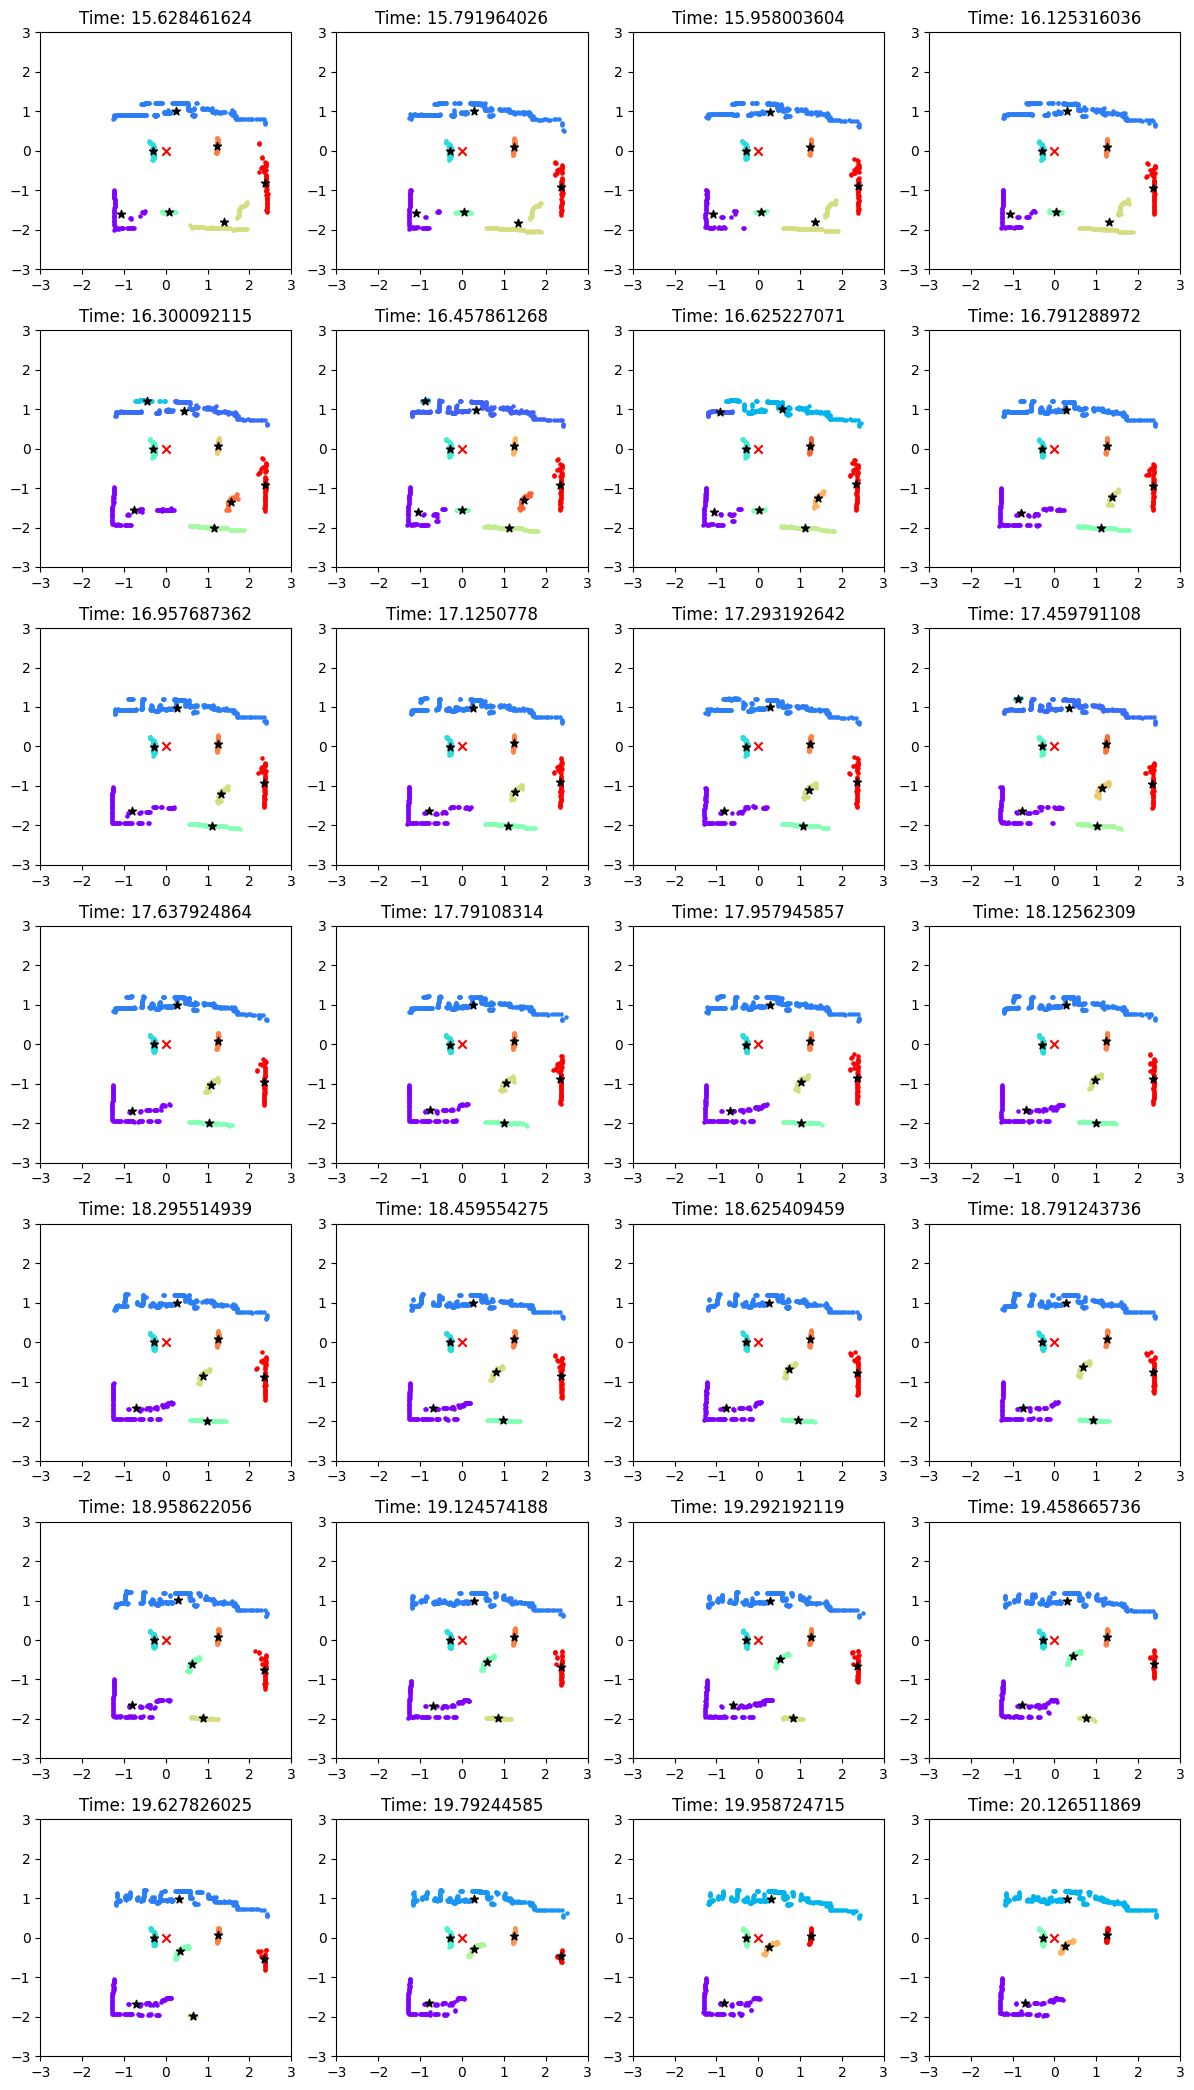

In [5]:
# Segmented visualization

figure, axis = plt.subplots(len(segments)//4, 4, figsize=(12, 21))
j = 0
for segment in segments:
    colors = []
    color_options = cm.rainbow(np.linspace(0, 1, len(segment) - 2))
    axis[j//4, j % 4].scatter(segment[1][3], segment[1][4],color="white")
    for i in range(2, len(segment)):
        axis[j//4, j % 4].scatter(segment[i][3], segment[i][4], color = color_options[segment[i][0] - 1], s=5)
        axis[j//4, j % 4].scatter(segment[i][1], segment[i][2], c="black", marker='*')
    axis[j//4, j % 4].scatter(0, 0, c="red", marker='x')
    axis[j//4, j % 4].set_xlim(-field_range, field_range)
    axis[j//4, j % 4].set_ylim(-field_range, field_range)
    axis[j//4, j % 4].set_title("Time: " + str(segment[0]))
    j += 1
plt.tight_layout()
plt.show()

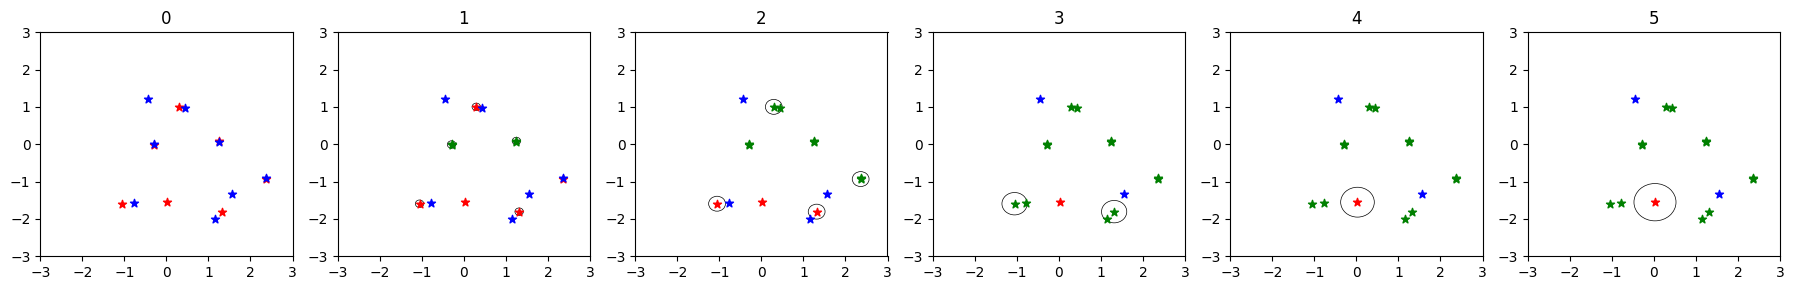

In [6]:
# Continuity Algorithm Demonstration

num_iterations = 6
max_range = 3

figure, axis = plt.subplots(1, num_iterations, figsize=(18, 3))
for i in range(4, 5):
    old = [(x[1], x[2], x[0]) for x in segments[i - 1][2:]]
    new = [(x[1], x[2], x[0]) for x in segments[i][2:]]
    checked = []
    for k in range(num_iterations):
        for j in old:
            for n in new:
                if (n[0] - j[0])**2 + (n[1] - j[1])**2 <= (max_range * (2 * field_range)/component_size * k/num_iterations)**2:
                    old.remove(j)
                    new.remove(n)
                    checked.append(j)
                    checked.append(n)
                    break
            circle = plt.Circle((j[0], j[1]), ((2 * field_range)/component_size * k/2), linewidth=0.5, edgecolor = 'black', facecolor="none")
            axis[k].add_patch(circle)
        axis[k].scatter([x[0] for x in old], [x[1] for x in old], c="red", marker='*')
        axis[k].scatter([x[0] for x in new], [x[1] for x in new], c="blue", marker='*')
        axis[k].scatter([x[0] for x in checked], [x[1] for x in checked], c="green", marker='*')
        axis[k].set_xlim(-field_range, field_range)
        axis[k].set_ylim(-field_range, field_range)
        axis[k].set_title(str(k))
plt.tight_layout()
plt.show()

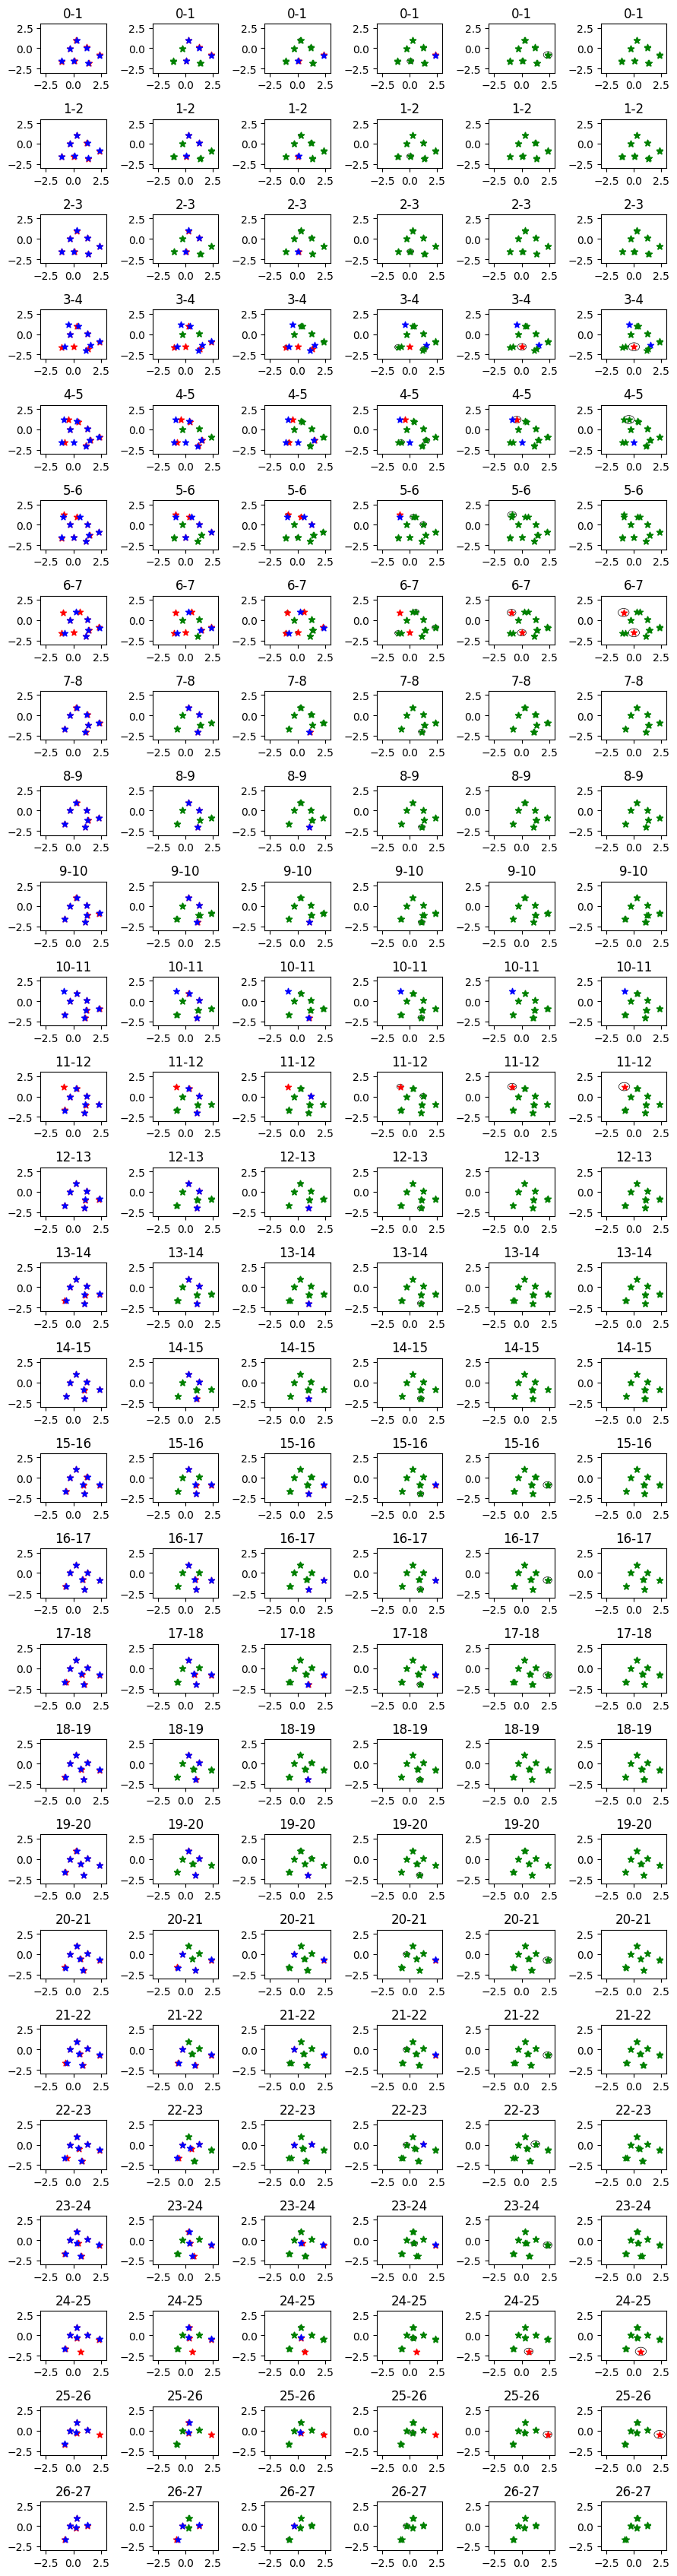

In [7]:
# Labeling with continuity

num_iterations = 6
max_range = 3

figure, axis = plt.subplots(len(segments) - 1, num_iterations, figsize=(9, 34))
for i in range(1, len(segments)):
    old = [(x[1], x[2], x[0]) for x in segments[i - 1][2:]]
    new = [(x[1], x[2], x[0]) for x in segments[i][2:]]
    checked = []
    for k in range(num_iterations):
        for j in old:
            for n in new:
                if (n[0] - j[0])**2 + (n[1] - j[1])**2 <=                                             \
                    (max_range * (2 * field_range)/component_size * k/num_iterations)**2:
                    old.remove(j)
                    new.remove(n)
                    segments[i][n[2] + 1][0] = j[2]
                    checked.append(j)
                    checked.append(n)
                    break
            circle = plt.Circle((j[0], j[1]), ((2 * field_range)/component_size * k/2),               \
                                linewidth=0.5, edgecolor = 'black', facecolor="none")
            axis[i - 1][k].add_patch(circle)
        axis[i - 1][k].scatter([x[0] for x in old], [x[1] for x in old], c="red", marker='*')
        axis[i - 1][k].scatter([x[0] for x in new], [x[1] for x in new], c="blue", marker='*')
        axis[i - 1][k].scatter([x[0] for x in checked], [x[1] for x in checked], c="green", marker='*')
        axis[i - 1][k].set_xlim(-field_range, field_range)
        axis[i - 1][k].set_ylim(-field_range, field_range)
        axis[i - 1][k].set_title(str(i - 1) + "-" + str(i))
    new_max = max([j[0] for j in segments[i - 1][2:]]) + 1
    for k in new:
        segments[i][k[2] + 1][0] = new_max
        new_max += 1
plt.tight_layout()
plt.show()

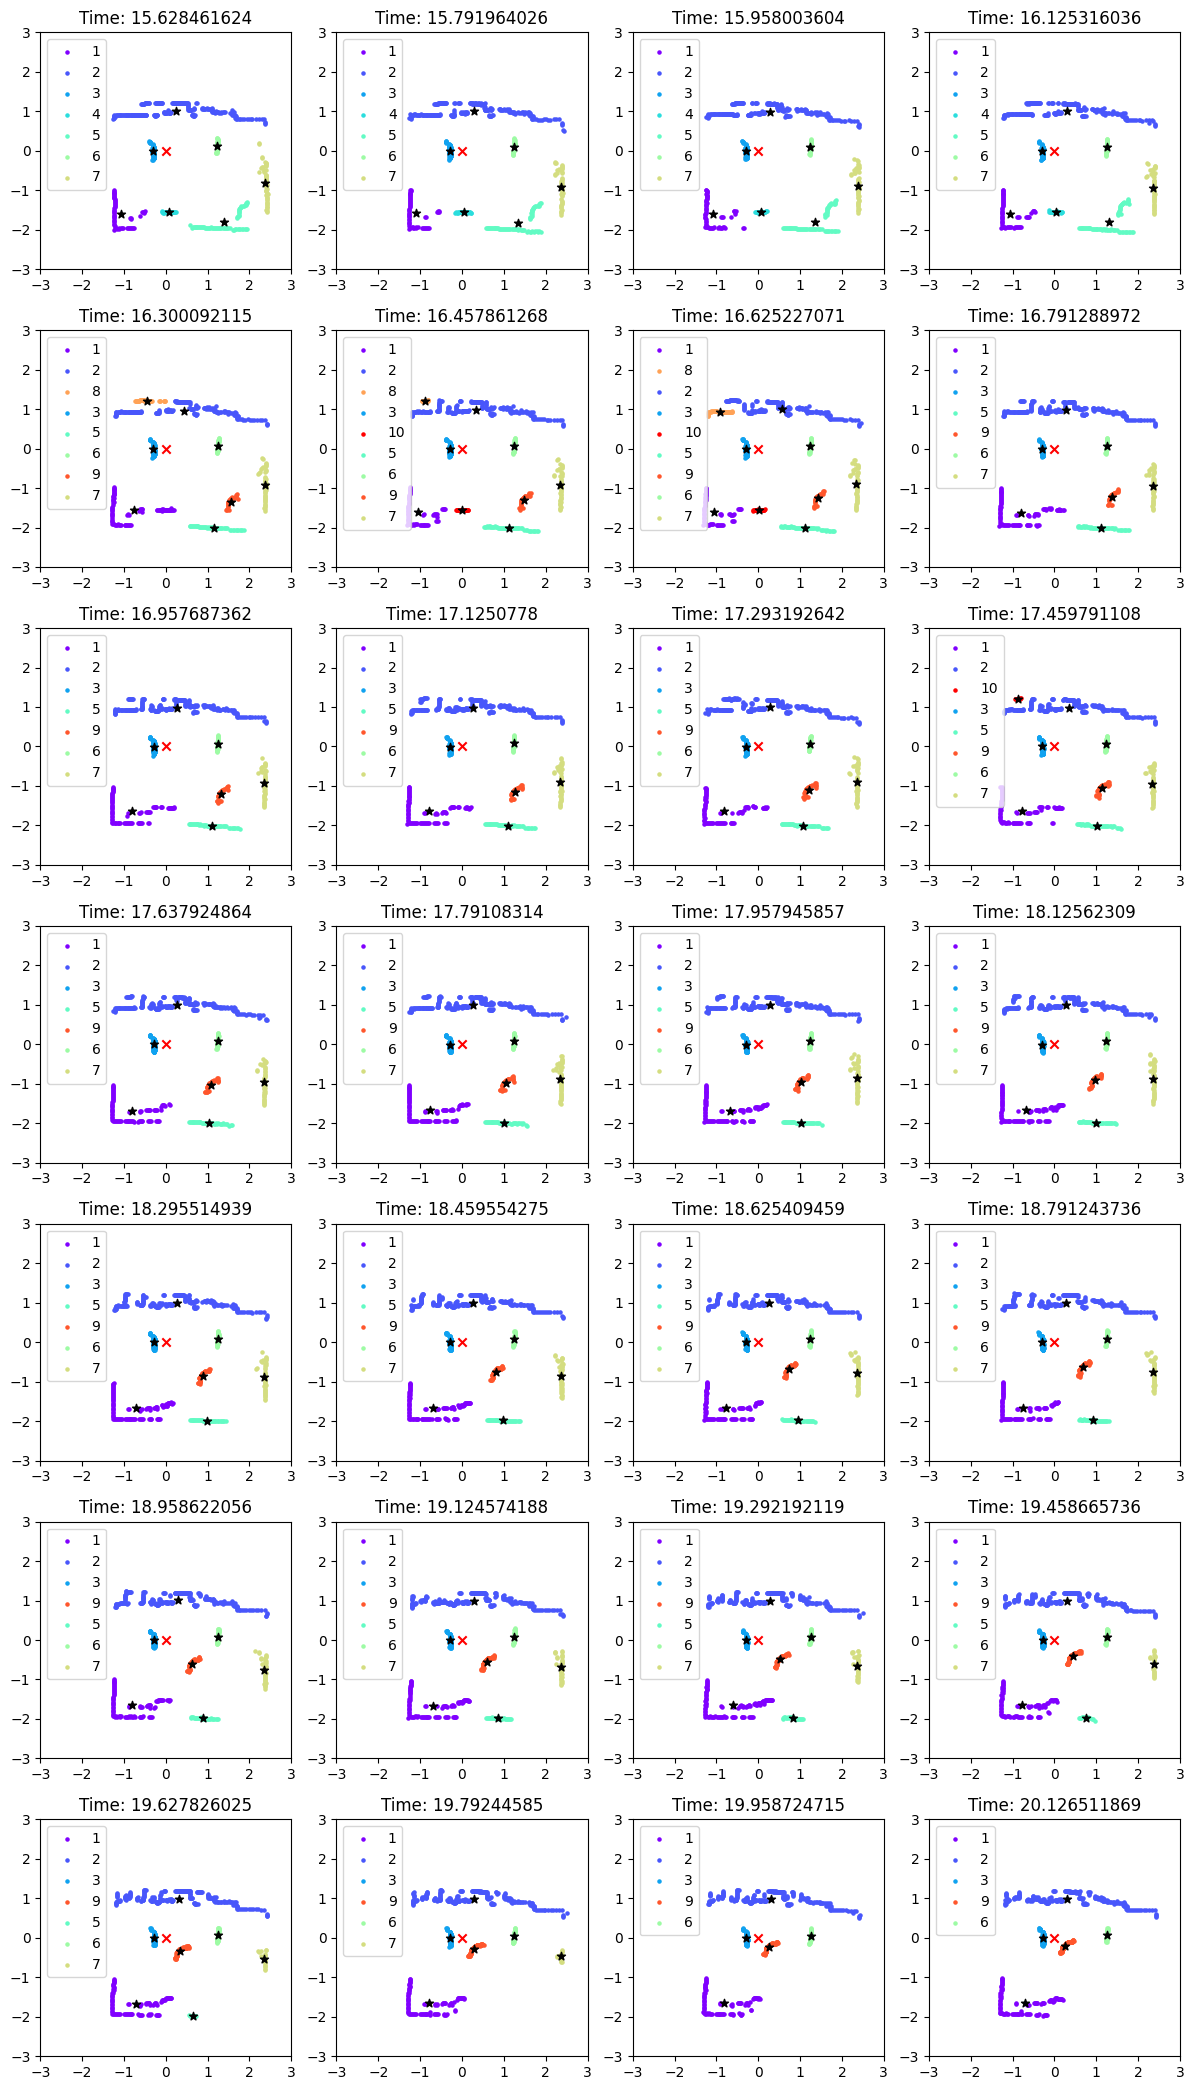

In [8]:
# Visualization with continuity

figure, axis = plt.subplots(len(segments)//4, 4, figsize=(12, 21))
color_options = cm.rainbow(np.linspace(0, 1, 10))
j = 0
for segment in segments:
    colors = []
    axis[j//4, j % 4].scatter(segment[1][3], segment[1][4],color="white")
    for i in range(2, len(segment)):
        axis[j//4, j % 4].scatter(segment[i][3], segment[i][4], color = color_options[segment[i][0] - 1], s=5,label=segment[i][0])
        axis[j//4, j % 4].scatter(segment[i][1], segment[i][2], c="black", marker='*')
    axis[j//4, j % 4].scatter(0, 0, c="red", marker='x')
    axis[j//4, j % 4].set_xlim(-field_range, field_range)
    axis[j//4, j % 4].set_ylim(-field_range, field_range)
    axis[j//4, j % 4].set_title("Time: " + str(segment[0]))
    axis[j//4, j % 4].legend()
    j += 1
plt.tight_layout()
plt.savefig('offline_segmentation.png')
plt.show()